### System Requirements:
* The model was trained on a PC with an RTX 2080 with 8Gb of VRAM. The model during training took roughly ~7 Gb of VRAM with a batch size of 32.
* The weights for the image model selected are 2461.6 MB and the weights for the text model is ~200 MB. Therefore, a minmimum VRAM of 4 Gb is probably required for training the model configuration. 

### Acknowledgement: 
* The following code is developed based on the tutorial of ENEN//ENEL 645 from Roberto Souza. Namely the [text-classification](https://github.com/rmsouza01/ENEL-ENEN-645-W2025/blob/main/Tutorials/garbage_classification_text.ipynb) and [image-classification](https://github.com/rmsouza01/ENEL-ENEN-645-W2025/blob/main/Tutorials/garbage_classifier_images.ipynb).
* ChatGPT was also used in the development and refinement of the code. 

### Overview:
* The model presented in this notebook is based on the results from [01_model_evaluation](01_model_evaluation.ipynb).
* The DistilBert model was used for the text component of the classificaiton as it was found to be adequate accuarcy at ~89% based on the provided tutorial.
* The [RegNET model](https://pytorch.org/vision/main/models/generated/torchvision.models.regnet_y_128gf.html#torchvision.models.RegNet_Y_128GF_Weights) was used due to its superior perfomrance compared to other pre-trained models avialable through Pytorch and through our evaluated results.
* The [Gated Fusion mechansim](https://arxiv.org/abs/1904.01803) was used as it was found to be superior to other methods trialed.

#### **Model Weights:**
* The model weights are not included on this repo or provided through Dropbox as they were 2.64 Gb after training. Therefore, if you require them, please contact me at jackson.cooper@ucalgary.ca and I would be happy to provide them.

In [1]:
# Required Imports
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm


In [2]:
# The data is read in based on the expected pre-structured classes and associated labels in the name. 
class MultiModalDataset(Dataset):
    def __init__(self, root_dir, tokenizer, max_len, image_transform=None):
        """
        Expects a folder structure:
            root_dir/
                class1/
                    image1.jpg
                    image2.jpg
                    ...
                class2/
                    ...
        The text is extracted from the file name (by removing extension, replacing underscores, etc.)
        """
        self.root_dir = root_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.image_transform = image_transform
        self.samples = []  # each element is a tuple (image_path, text, label)
        self.class_folders = sorted(os.listdir(root_dir))
        self.label_map = {cls: idx for idx, cls in enumerate(self.class_folders)}
        
        for cls in self.class_folders:
            cls_path = os.path.join(root_dir, cls)
            if os.path.isdir(cls_path):
                for file in sorted(os.listdir(cls_path)):
                    file_path = os.path.join(cls_path, file)
                    if os.path.isfile(file_path):
                        file_name_no_ext, _ = os.path.splitext(file)
                        text = file_name_no_ext.replace('_', ' ')
                        text = re.sub(r'\d+', '', text)
                        self.samples.append((file_path, text, self.label_map[cls]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        image_path, text, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.image_transform:
            image = self.image_transform(image)
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'image': image,
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long),
            'file_name': os.path.basename(image_path)
        }
    

After defining our data class, we can create the model to be trained. 

In [3]:
# The model uses DistilBERT for text and a RegNet model for images.
# A gating mechanism fuses the two modalities.
class MultiModalClassifier(nn.Module):
    def __init__(self, num_classes, fusion_dim=512, text_model_name='distilbert-base-uncased', freeze_image_layers=True):
        """
        fusion_dim: common embedding dimension for both modalities.
        freeze_image_layers: if True, freeze most image model parameters except for the last stage ('s4'),
        ensuring that only one layer (i.e. the s4 block) is tuned in the vision branch.
        """
        super(MultiModalClassifier, self).__init__()
        self.fusion_dim = fusion_dim
        
        # ---- Text model: DistilBERT ----
        self.text_model = DistilBertModel.from_pretrained(text_model_name)
        self.text_projection = nn.Linear(self.text_model.config.hidden_size, fusion_dim)
        self.text_dropout = nn.Dropout(0.5)
        
        # ---- Image model: RegNet_Y_128GF ----
        self.image_model = models.regnet_y_128gf(weights=models.RegNet_Y_128GF_Weights.IMAGENET1K_SWAG_E2E_V1)
        # Remove the final fc layer to obtain features.
        image_feature_dim = self.image_model.fc.in_features
        self.image_model.fc = nn.Identity()
        
        if freeze_image_layers:
            # Freeze all parameters except those in the last stage ('s4').
            for name, param in self.image_model.named_parameters():
                if not name.startswith('s4'):
                    param.requires_grad = False
        
        # If necessary, project image features to fusion_dim.
        if image_feature_dim != fusion_dim:
            self.image_projection = nn.Linear(image_feature_dim, fusion_dim)
        else:
            self.image_projection = nn.Identity()
        self.image_dropout = nn.Dropout(0.5)
 
        # ---- Gating Mechanism for Fusion ----
        # This mechanism learns how to weight text and image features.
        self.gate = nn.Sequential(
            nn.Linear(fusion_dim * 2, fusion_dim),
            nn.ReLU(),
            nn.Linear(fusion_dim, fusion_dim),
            nn.Sigmoid()
        )
        self.fusion_dropout = nn.Dropout(0.5)
        
        # ---- Classification Head ----
        self.classifier = nn.Linear(fusion_dim, num_classes)
    
    def forward(self, input_ids, attention_mask, image):
        # Text branch
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_feat = text_outputs.last_hidden_state[:, 0, :]  # Use [CLS] token
        text_feat = self.text_dropout(text_feat)
        text_feat = self.text_projection(text_feat)
        
        # Image branch
        image_feat = self.image_model(image)
        image_feat = self.image_dropout(image_feat)
        image_feat = self.image_projection(image_feat)
        
        # Fusion via gating mechanism
        # Pretty much this fusion mechanism balances between the two models to limit potential noise from either model
        gate_weights = self.gate(torch.cat([text_feat, image_feat], dim=1))
        fused_feat = gate_weights * text_feat + (1 - gate_weights) * image_feat
        fused_feat = self.fusion_dropout(fused_feat)
        
        logits = self.classifier(fused_feat)
        return logits


Several data augnmentations were applied to the image dataset to help improve generalizability to new imagery. This includes geometric changes such as spatial transformations (no camera distortion was applied but could be useful if your new imagery is not expected to be calibrated). As well as radiometric adjustments. It is worth noting, that in the dataset, several examples looked to have a masked background, i.e a white background, so applying masking as an additioanl augmentation to the dataset may be valuable. 

You could potentially apply transformations to the text, such as the use of syonymns, or translations, however, I have not worked with that before, and am unaware how useful it would be in practice. 

In [4]:
# Define image transformations and initialize the tokenizer.
train_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_len = 24

# Paths for train, validation, and test datasets.
TRAIN_PATH = './garbage_data/CVPR_2024_dataset_Train'
VAL_PATH = './garbage_data/CVPR_2024_dataset_Val'
TEST_PATH = './garbage_data/CVPR_2024_dataset_Test'

# Create dataset instances.
train_dataset = MultiModalDataset(TRAIN_PATH, tokenizer, max_len, image_transform=train_image_transform)
val_dataset = MultiModalDataset(VAL_PATH, tokenizer, max_len, image_transform=val_test_transform)
test_dataset = MultiModalDataset(TEST_PATH, tokenizer, max_len, image_transform=val_test_transform)


Using a weighted sampler to ensure we are balancing between the classes, as the blue cart class is nearly 2x representation of the other individual classes. 

In [5]:
# Use a WeightedRandomSampler to handle class imbalance in the training data.
train_labels = [sample[2] for sample in train_dataset.samples]
class_counts = np.bincount(train_labels)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in train_labels]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 4

# Instantiate the multimodal classifier.
model = MultiModalClassifier(num_classes=num_classes, fusion_dim=512, freeze_image_layers=True)
model = model.to(device)

# Define the optimizer, loss function, and learning rate scheduler.
# Basing off of the tutorial, and trialed parameters
optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [7]:
# The following functions handle a single training epoch and evaluation on validation data.
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    running_corrects = 0
    total_samples = 0
    batch_losses = []
    batch_accs = []
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        running_corrects += torch.sum(preds == labels).item()
        total_samples += labels.size(0)
        
        # Batch metrics
        batch_loss = loss.item()
        batch_accuracy = (torch.sum(preds == labels).item() / labels.size(0))
        batch_losses.append(batch_loss)
        batch_accs.append(batch_accuracy)
        
        progress_bar.set_postfix(loss=batch_loss, accuracy=batch_accuracy)
    
    epoch_loss = total_loss / len(dataloader)
    epoch_acc = running_corrects / total_samples
    return epoch_loss, epoch_acc, batch_losses, batch_accs

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    batch_losses = []
    batch_accs = []
    
    progress_bar = tqdm(dataloader, desc="Validation", leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            
            # Batch metrics for evaluation
            batch_loss = loss.item()
            batch_accuracy = (torch.sum(outputs.argmax(dim=1) == labels).item() / labels.size(0))
            batch_losses.append(batch_loss)
            batch_accs.append(batch_accuracy)
            
            progress_bar.set_postfix(loss=batch_loss, accuracy=batch_accuracy)
    
    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return avg_loss, acc, cm, batch_losses, batch_accs



In [ ]:
# Initialize metric tracking lists.
train_losses = []
train_accs = []
val_losses = []
val_accs = []

train_batches_losses = []
train_batches_accs = []
val_batches_losses = []
val_batches_accs = []

# Early stopping parameters.
EPOCHS = 10
best_val_loss = float('inf')
patience = 2
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    train_loss, train_acc, epoch_train_batch_losses, epoch_train_batch_accs = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_cm, epoch_val_batch_losses, epoch_val_batch_accs = evaluate_model(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    train_batches_losses.append(epoch_train_batch_losses)
    train_batches_accs.append(epoch_train_batch_accs)
    val_batches_losses.append(epoch_val_batch_losses)
    val_batches_accs.append(epoch_val_batch_accs)
    
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc*100:.2f}%")
    print(f"  Confusion Matrix:\n{val_cm}\n")
    
    scheduler.step()
    print("Current LR:", scheduler.optimizer.param_groups[0]['lr'])
    
    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_multimodal_model.pth')
        print("Model improved. Saving model.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

### Training Results from the Current Evalauted Model Below

Epoch 1/10

  Train Loss: 0.5469 | Train Acc: 79.01%
  Val   Loss: 0.3523 | Val   Acc: 87.61%
  Confusion Matrix:
[[313  27   3  29]
 [ 54 665  22  27]
 [ 10  16 319   7]
 [ 11  15   2 280]]

Current LR: 1.9271177344544742e-05
Model improved. Saving model. 

Epoch 2/10


  Train Loss: 0.2809 | Train Acc: 90.54%
  Val   Loss: 0.3587 | Val   Acc: 86.94%
  Confusion Matrix:
[[339  15   2  16]
 [ 86 634  28  20]
 [ 16  11 321   4]
 [ 24  12   1 271]]

Current LR: 1.9258305525889206e-05
No improvement in validation loss. Patience counter: 1/2

Epoch 3/10

  Train Loss: 0.2228 | Train Acc: 92.35%
  Val   Loss: 0.2998 | Val   Acc: 89.56%
  Confusion Matrix:
[[323  30   3  16]
 [ 42 697  16  13]
 [  4  19 325   4]
 [ 25  15   1 267]]

Current LR: 1.9378124908687465e-05
Model improved. Saving model.

Epoch 4/10

  Train Loss: 0.1875 | Train Acc: 93.31%
  Val   Loss: 0.3329 | Val   Acc: 89.56%
  Confusion Matrix:
[[329  24   3  16]
 [ 41 685  28  14]
 [  7  14 327   4]
 [ 19  14   4 271]]

Current LR: 1.9310686470668903e-05
No improvement in validation loss. Patience counter: 1/2

Epoch 5/10
                                                                                                                        

  Train Loss: 0.1679 | Train Acc: 94.26%
  Val   Loss: 0.3080 | Val   Acc: 89.61%
  Confusion Matrix:
[[320  26   4  22]
 [ 37 688  24  19]
 [  4  17 326   5]
 [ 14  12   3 279]]

Current LR: 1.936136835732785e-05
No improvement in validation loss. Patience counter: 2/2
Early stopping triggered.



In [8]:
# Loading the best saved model before evaluating on the test set
model.load_state_dict(torch.load('best_multimodal_model.pth'))
model.to(device)  # Ensure the model is on the correct device

# Now evaluate on the test set
test_loss, test_acc, test_cm, test_batch_losses, test_batch_accs = evaluate_model(model, test_loader, criterion, device)

print("Test Results (Best Model)")
print(f"  Test Loss:   {test_loss:.4f} | Accuracy: {test_acc*100:.2f}%")
print(f"  Confusion Matrix:\n{test_cm}")


Test Results (Best Model)
  Test Loss:   0.4336 | Accuracy: 85.64%
  Confusion Matrix:
[[527  93  21  54]
 [ 61 981  31  13]
 [ 23  17 756   3]
 [ 82  80  15 675]]


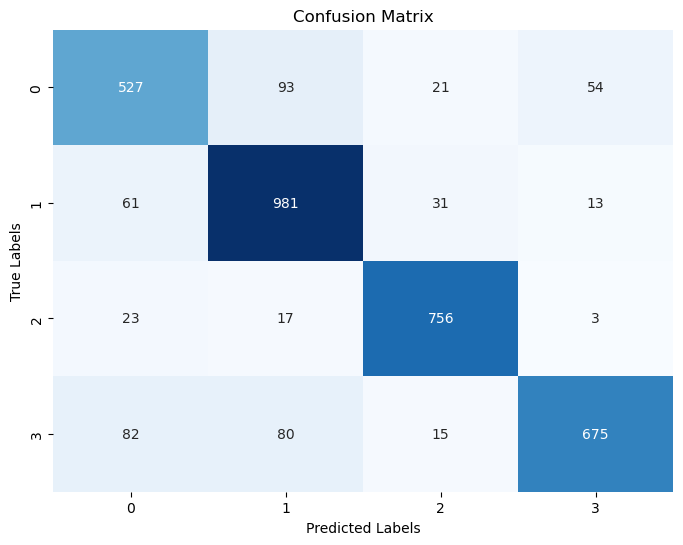

In [9]:
# Plotting a confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [18]:
# Overall accuracy: Sum of diagonal elements divided by total sum
accuracy = np.trace(test_cm) / np.sum(test_cm)

# Precision for each class: TP / (TP + FP)
precision = np.diag(test_cm) / np.sum(test_cm, axis=0)

# Recall for each class: TP / (TP + FN)
recall = np.diag(test_cm) / np.sum(test_cm, axis=1)

# F1-score for each class: harmonic mean of precision and recall
f1_scores = 2 * precision * recall / (precision + recall)

# Macro averages: simple average over classes
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1_scores)

# Weighted averages: weighted by the support (true instances per class)
support = np.sum(test_cm, axis=1)
weighted_precision = np.sum(precision * support) / np.sum(support)
weighted_recall = np.sum(recall * support) / np.sum(support)
weighted_f1 = np.sum(f1_scores * support) / np.sum(support)

print("Accuracy:", accuracy)
print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-scores per class:", f1_scores)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1:", macro_f1)
print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)
print("Weighted F1:", weighted_f1)

Accuracy: 0.8563519813519813
Precision per class: [0.76046176 0.83774552 0.91859052 0.90604027]
Recall per class: [0.75827338 0.90331492 0.94618273 0.79225352]
F1-scores per class: [0.75936599 0.86929553 0.93218249 0.845335  ]
Macro Precision: 0.8557095170123266
Macro Recall: 0.8500061369898274
Macro F1: 0.8515447532881424
Weighted Precision: 0.8578708306500027
Weighted Recall: 0.8563519813519813
Weighted F1: 0.855726555640676


To better understand the performance of classificaiton, I plot sampled prediciton results for the different classes (both correct and incorrect). These results can be seen in the accompanying [PDF](evaluated_results.pdf). 

Broadly speaking, these results to be failry resonable, as several of the objects I would have difficulty classfying myself. In particular, some items such as the dryer sheet, and the binder in the TTR class, I would personally have put into the Black bin. 

Therefore, the results determined with our model may be best compared to a human expert in classfying. This would provide a better understanding of how well the model is actually performing in the real world. 

It would also potentially be valuable in auding the dataset of the model to ensure that items are in the appropraite classes. 

In [19]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from matplotlib.backends.backend_pdf import PdfPages  

np.random.seed(1234)

# Helper: Denormalize an image tensor for visualization.
def denormalize(img_tensor):
    # Mean and std must match the ones used during normalization.
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    img = img.clamp(0, 1)
    return img.permute(1, 2, 0).numpy()

# Create a subset from the test dataset to speed up inference.
subset_size = min(100, len(test_dataset))
subset_indices = np.random.choice(len(test_dataset), size=subset_size, replace=False)
subset_test = Subset(test_dataset, subset_indices)
subset_test_loader = DataLoader(subset_test, batch_size=32, shuffle=False)

# Run inference on the subset.
model.eval()
all_preds = []
all_labels = []
all_file_names = []
all_images = []

with torch.no_grad():
    for batch in subset_test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        file_names = batch['file_name']  # 'file_name' must be returned by your dataset
        
        outputs = model(input_ids, attention_mask, images)
        preds = outputs.argmax(dim=1)
        
        for i in range(len(labels)):
            all_preds.append(preds[i].item())
            all_labels.append(labels[i].item())
            all_file_names.append(file_names[i])
            all_images.append(images[i].cpu())

# Create reverse mapping from label index to class name.
idx_to_class = {v: k for k, v in test_dataset.label_map.items()}

# Open a PdfPages object to save multiple figures into a single PDF.
with PdfPages('evaluated_results.pdf') as pdf:
    # For each class, sample up to N=4 correct and N=4 incorrect predictions.
    N = 4
    for class_idx in sorted(idx_to_class.keys()):
        # Get indices for samples of the current class.
        indices = [i for i, label in enumerate(all_labels) if label == class_idx]
        correct_indices = [i for i in indices if all_preds[i] == class_idx]
        incorrect_indices = [i for i in indices if all_preds[i] != class_idx]
        
        # Sample up to N examples from each group.
        sampled_correct = random.sample(correct_indices, min(N, len(correct_indices)))
        sampled_incorrect = random.sample(incorrect_indices, min(N, len(incorrect_indices)))
        
        # Plotting: Two rows (correct on top, incorrect on bottom) with N columns.
        fig, axes = plt.subplots(2, N, figsize=(N * 4, 8))
        fig.suptitle(f"Class: {idx_to_class[class_idx]}", fontsize=16)
        
        # Top row: Correct predictions.
        for j in range(N):
            ax = axes[0, j] if N > 1 else axes[0]
            if j < len(sampled_correct):
                idx = sampled_correct[j]
                img = denormalize(all_images[idx])
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"File: {all_file_names[idx]}\nPred: {idx_to_class[all_preds[idx]]}", fontsize=10)
            else:
                ax.axis('off')
        axes[0, 0].set_ylabel("Correct", fontsize=14)
        
        # Bottom row: Incorrect predictions.
        for j in range(N):
            ax = axes[1, j] if N > 1 else axes[1]
            if j < len(sampled_incorrect):
                idx = sampled_incorrect[j]
                img = denormalize(all_images[idx])
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"File: {all_file_names[idx]}\nPred: {idx_to_class[all_preds[idx]]}", fontsize=10)
            else:
                ax.axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        # Save the current figure as a page in the PDF.
        pdf.savefig(fig)
        plt.close(fig)
